### focus stacking w.r.t. distance from focus

In [1]:
import numpy as np
import subprocess
import glob
import skimage.io as imio
import re
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
%matplotlib inline
import time

## camera behavior
def initialFocus(sid=0):
    #10.42.0.90: local 10.236.176.75: ip
    cmD='ssh nvidia@10.236.176.75 "echo "nvidia" | sudo -S ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -init "'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout
def moveFocus(sid=0, pos=512):
    cmD='ssh nvidia@10.236.176.75 "echo "nvidia" | sudo -S ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -mod '+str(pos)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout
def setFocus(sid=0, pos=512):
    cmD='ssh nvidia@10.236.176.75 "echo "nvidia" | sudo -S ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -set '+str(pos)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout

def grab_image(sid=0, imres=8):
# I will use the file name dbGrab.... for the image grabbed from the camera. First step is to get rid of previously grabbed images

    subprocess.run('ssh nvidia@10.236.176.75 "rm dbGrab*"', \
                   stdout=subprocess.PIPE, shell=True)

    # ok, now let's grab an image on the tegra
    subprocess.run('ssh nvidia@10.236.176.75 "nvgstcapture-1.0 -m 1 --sensor-id '+str(sid)+' -A --capture-auto 1 \
                    --file-name dbGrab --image-res '+str(imres)+'"', stdout=subprocess.PIPE, shell=True)
    subprocess.run('scp nvidia@10.236.176.75:dbGrab* .', \
                   stdout=subprocess.PIPE, shell=True)
    #ok, now let's find the file name of the image we just grabbed and transfered 
    pop=subprocess.run('ls',stdout=subprocess.PIPE, shell=True)
    rePop=pop.stdout
    rePop=rePop.decode("utf-8")
    fileName = re.search(r'dbGrab(.*).jpg', rePop)
    fileName=fileName.group()
    pop=imio.imread(fileName)
#     pop=skimage.transform.rotate(pop,180)
    subprocess.run('mv dbGrab* photo_arch/', \
                   stdout=subprocess.PIPE, shell=True)
    
    return pop

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
set_session(tf.Session(config=config))
from tensorflow.python.keras.models import load_model
dist_est_net = load_model('050-0.65.hdf5')
from quad_solver import solver
#     curr0 = curr + solver(curr, step)[0]
#     curr1 = curr + solver(curr, step)[1]

Using TensorFlow backend.
W1120 11:38:51.989493 139943190722304 deprecation.py:506] From /home/qian/anaconda3/envs/pytorch/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1120 11:38:51.990692 139943190722304 deprecation.py:506] From /home/qian/anaconda3/envs/pytorch/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [3]:
## blockwise estimate focus status
def reflect_pad(img, left, up):
    return np.pad(img, ((up, up), (left, left)), 'reflect')

def stack_blocks(img, window_size, step):
    H, W = img.shape
    stack = []
    for i in range(0, H, step):
        for j in range(0, W, step):
            stack.append(img[i:i+window_size, j:j+window_size])
    stack = np.stack(stack)[..., np.newaxis]
    return stack
    
def dist_est(gray_img, curr, last_dist_map = None, last_move_steps = None):
    # dist_list contain blockwise dist it stores. 0 indicates the block has been in-focused before.
    # last_move_steps 
    H, W = gray_img.shape
    window_size = 512
    step = 512
    if H % window_size != 0:
        up = (window_size - (H % window_size))//2
    if W % window_size != 0:
        left = (window_size - (W % window_size))//2
    gray_img = reflect_pad(gray_img, left, up)
    H, W = gray_img.shape

    if last_dist_map is None:
        last_dist_map = np.ones((H//step, W//step))
    
    dist_map = np.zeros(last_dist_map.shape)
      

    gray_img_stack = stack_blocks(gray_img, window_size, step)
    stime = time.time()
    
    dst_stack = dist_est_net.predict(gray_img_stack)
    #print("network runtime elapsed: {}".format(time.time()-stime))
    dst_stack = dst_stack.reshape(H//step, W//step)
#     for i in range(H//step):
#         for j in range(W//step):
#             if last_dist_map[i, j] != 0:
#                 dst = dst_stack[i, j]
#                 if dst < 2:
#                     dst=0
#                 dist_map[i, j] = dst
    dist_map = dst_stack

    stime = time.time()
    
    if last_move_steps is not None:
        ## Focus direction: simple check
        mapa = dist_map - last_move_steps
        mapb = -dist_map - last_move_steps
        diffa = np.abs(mapa) - last_dist_map
        diffb = np.abs(mapb) - last_dist_map
        mask = (np.abs(diffa) < np.abs(diffb)).astype(np.float64)
        dist_map = (dist_map * mask + (1-mask) * (-dist_map))

    ## grouping and pick one distance to move
    dist_vec = dist_map.flatten()
    #dist_vec = dist_vec[dist_vec!=0]
    dist_vec = dist_vec[np.abs(dist_vec)>2.5]
    n, bins, patches = plt.hist(dist_vec, bins=10)

    idx_sorted = np.argsort(n)[::-1]
    flag = False
    for i in range(len(n)):
        dist_to_move = -(bins[idx_sorted[i]]+bins[idx_sorted[i]+1])/2
        #print("trial {}: est curr: {}".format(i, curr + solver(curr, dist_to_move)))
        if (curr + solver(curr, dist_to_move) > 375) and (curr + solver(curr, dist_to_move) < 1100):
            flag = True
            break
    
    #print("grouping and findmax time elapsed: {}".format(time.time()-stime))
    plt.show()
    plt.imshow((dist_map))
    plt.colorbar()
    plt.show()
    
    return flag, np.abs(dist_map), dist_to_move


In [10]:
# #initialFocus()
curr = 700
# setFocus(pos = curr)

# img = grab_image()
# gray_img = rgb2gray(img)

# plt.imshow(gray_img)
# plt.show()
# print(gray_img.max())

In [11]:
dist_map = None
dist_to_move = None
# while (dist_map is None) or (np.max(dist_map) > 1):

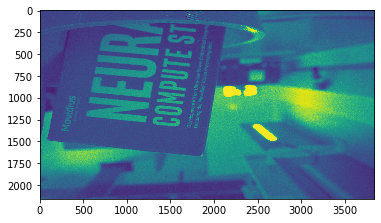

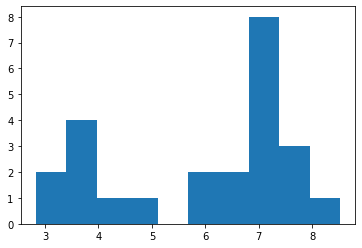

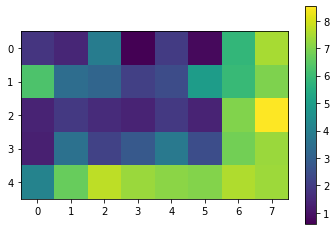

distance to move:  -7.097614288330078
round 1 -- current focus pos is: 425.0


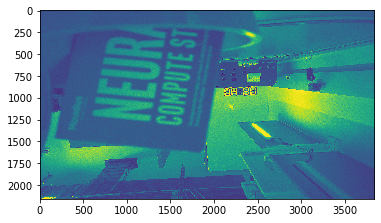

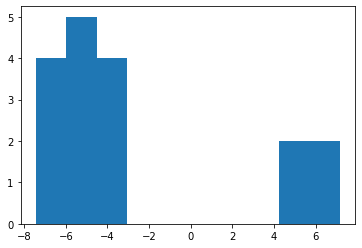

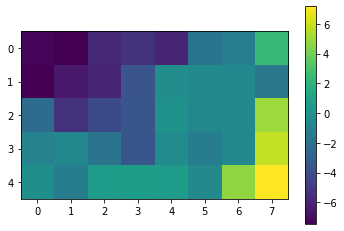

distance to move:  5.247191333770752
round 2 -- current focus pos is: 626.2718213802734


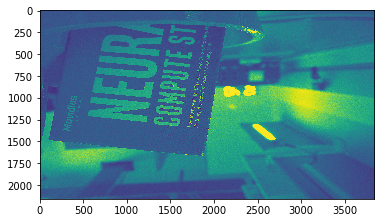

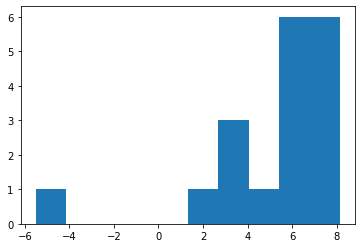

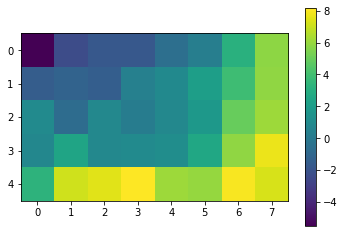

distance to move:  -7.470960426330566
round 3 -- current focus pos is: 425.0


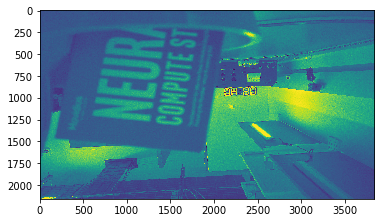

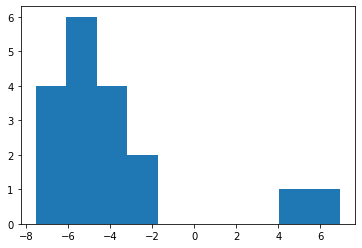

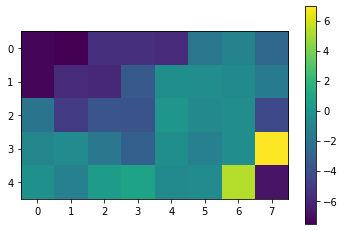

distance to move:  5.368241763114929
round 4 -- current focus pos is: 631.7635763390749


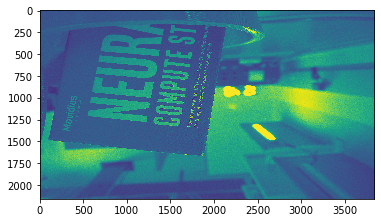

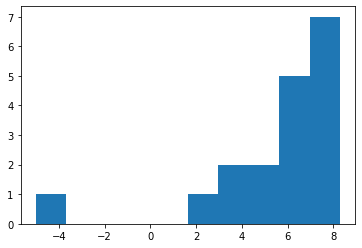

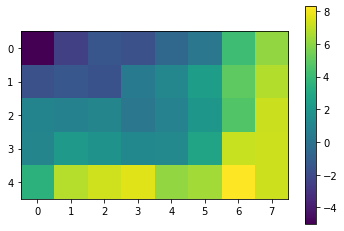

distance to move:  -7.635276651382447
round 5 -- current focus pos is: 425.0


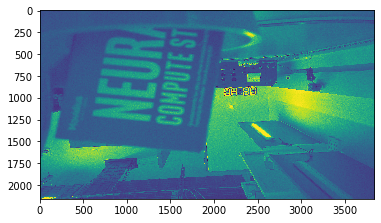

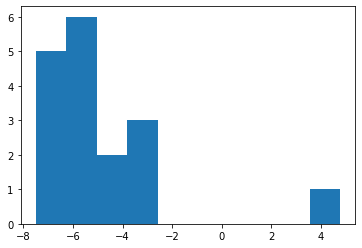

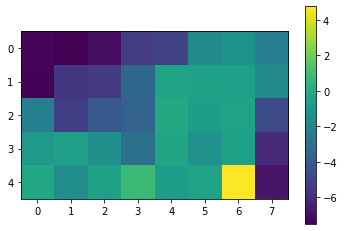

distance to move:  5.659077048301697
round 6 -- current focus pos is: 645.1823149000727


In [12]:
imgs = []
for i in range(6):
    setFocus(pos = curr)
    img = grab_image()
    imgs.append(img)
    gray_img = rgb2gray(img)

    plt.imshow(gray_img)
    plt.show()
    flag, dist_map, dist_to_move = dist_est(gray_img, curr, dist_map, dist_to_move)

    if flag is False:
        break
    print("distance to move: ", dist_to_move)
    curr = curr + solver(curr, dist_to_move)
    curr = np.clip(curr, 425, 1023)
    print("round {} -- current focus pos is: {}".format(i+1, curr))
imgs = np.stack(imgs)
#     print(dist_map)


In [7]:
import sys, os
os.chdir('/home/qian/Documents/pyFusion/')
from awnet import pwc_5x5_sigmoid_bilinear   # cm:import AWnet model
import torch

AWnet = pwc_5x5_sigmoid_bilinear.pwc_residual().cuda()
AWnet.load_state_dict(torch.load('awnet/fs0_61_294481_0.00919393_dict.pkl'))
AWnet = AWnet.eval()

def fuseTwoImages(I, J_hat):
    with torch.no_grad():
        fusedTensor,warp,mask = AWnet(J_hat,I)
    return fusedTensor, warp, mask

/tmp/pip-req-build-0vti0ns4/torch/csrc/autograd/python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/tmp/pip-req-build-0vti0ns4/torch/csrc/autograd/python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/tmp/pip-req-build-0vti0ns4/torch/csrc/autograd/python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/tmp

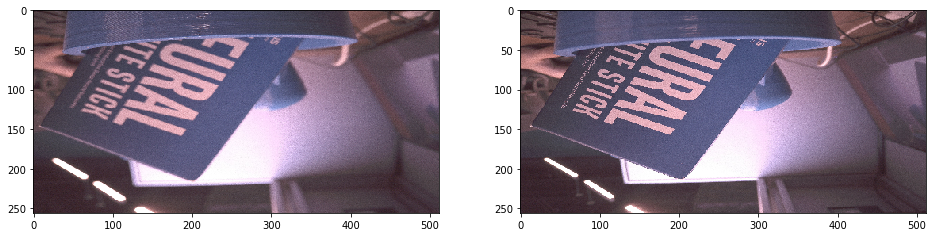

W1111 11:40:35.295557 140660117591808 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


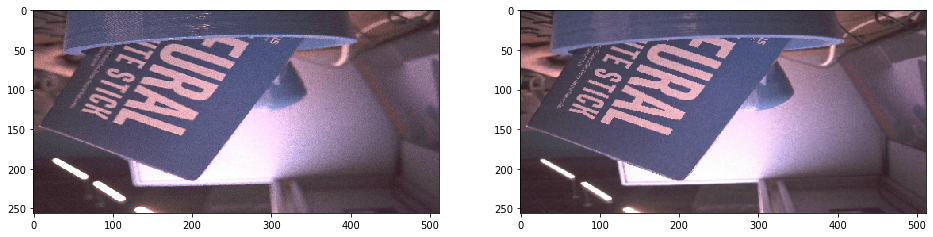

In [8]:
import torch
import cv2

# def padding(img, left, up):
    
#     return np.pad(img, ((up, up), (left, left), (0, 0)), 'constant')

# img1 = cv2.imread('/media/qian/My Passport/DKU_SERVER_BACKUP/CU5/databases/fs_davis/train/lr/lr_08470.png')[..., ::-1]/255.
# img2 = cv2.imread('/media/qian/My Passport/DKU_SERVER_BACKUP/CU5/databases/fs_davis/train/lr/lr_08471.png')[..., ::-1]/255.

# img1 = padding(img1, 21, 16)
# img2 = padding(img2, 21, 16)

img1 = imgs[2]
img2 = imgs[1]

img1 = cv2.resize(img1, (512, 256))/255.
img2 = cv2.resize(img2, (512, 256))/255.

img1T = torch.Tensor(img1.transpose(2, 0, 1)).unsqueeze(0).cuda()
img2T = torch.Tensor(img2.transpose(2, 0, 1)).unsqueeze(0).cuda()
fused, warp, mask = fuseTwoImages(img1T, img2T)

fig, ax = plt.subplots(1, 2, figsize = (16, 8))
ax[0].imshow(img1)
ax[1].imshow(img2)
plt.show()

fig, ax = plt.subplots(1, 2, figsize = (16, 8))
ax[0].imshow(fused.squeeze().cpu().numpy().transpose(1, 2, 0))
ax[1].imshow(warp.squeeze().cpu().numpy().transpose(1, 2, 0))
plt.show()

In [9]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error
import tensorflow.keras as keras
import numpy as np

def encoder_block(x, _filters, _kernel_size, _strides, bn = True):
    y = layers.Conv2D(filters = _filters, kernel_size = _kernel_size, 
                      strides = _strides, padding="same",
                      kernel_initializer = keras.initializers.RandomNormal(stddev=0.02))(x)
    if bn is True:
        y = layers.BatchNormalization(momentum = 0.9, epsilon=1e-5)(y)
    y = layers.ReLU()(y)
    return y
def encoder_net(y):
    y = encoder_block(y, 32, (5, 5), (4, 4), bn = False)
    y = encoder_block(y, 128, (5, 5), (4, 4))
    y = encoder_block(y, 256, (5, 5), (4, 4))
    y = encoder_block(y, 256, (5, 5), (4, 4))
    return y
def decoder_block(x, _filters, _kernel_size, _strides, dropout = False):
    y = layers.Conv2DTranspose(filters = _filters, kernel_size = _kernel_size, 
                               strides=_strides, padding="same",
                               kernel_initializer=keras.initializers.RandomNormal(stddev=0.02))(x)
    y = layers.BatchNormalization(momentum = 0.9, epsilon=1e-5)(y)
    if dropout is True:
        y = layers.Dropout(0.5)(y)
    y = layers.ReLU()(y)
    return y
def decoder_net(y):
    y = decoder_block(y, 256, (5, 5), (4, 4))
    y = decoder_block(y, 256, (5, 5), (4, 4), False)
    y = decoder_block(y, 128, (5, 5), (4, 4), False)
    y = decoder_block(y, 32, (5, 5), (4, 4), False)
    y = encoder_block(y, 16, (5, 5), (1, 1), bn = False)
    y = layers.Conv2D(filters = 1, kernel_size = (5, 5), padding = "same",
                      activation="tanh",
                      kernel_initializer = keras.initializers.RandomNormal(stddev=0.02))(y)
    return y
def fusionnet(inTensor1, inTensor2):
    out1 = encoder_net(inTensor1)
    out2 = encoder_net(inTensor2)
    x = layers.Concatenate(axis = -1)([out1, out2])
    y = decoder_net(x)
    return y
def fusionnetPos(y):
    y, inTensor1, inTensor2 = y
    y = tf.tile(y, [1, 1, 1, 3])
    y1 = layers.Multiply()([inTensor1, (1+y)/2])
    y2 = layers.Multiply()([inTensor2, 1-(1+y)/2])
    y = layers.Add()([y1, y2])
    return y
img_1 = layers.Input(shape=(None, None, 3))
img_2 = layers.Input(shape=(None, None, 3))
intermed = fusionnet(img_1, img_2) # intermed: mask layer

pred = layers.Lambda(fusionnetPos)([intermed, img_1, img_2])
FusionNet = Model(inputs = [img_1, img_2], outputs = [pred, intermed])
FusionNet.load_weights('/home/qian/Downloads/my_model_300e_5e-3_weights.h5')

W1111 11:40:35.911798 140660117591808 deprecation.py:506] From /home/qian/anaconda3/envs/pytorch/lib/python3.6/site-packages/tensorflow/python/keras/initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


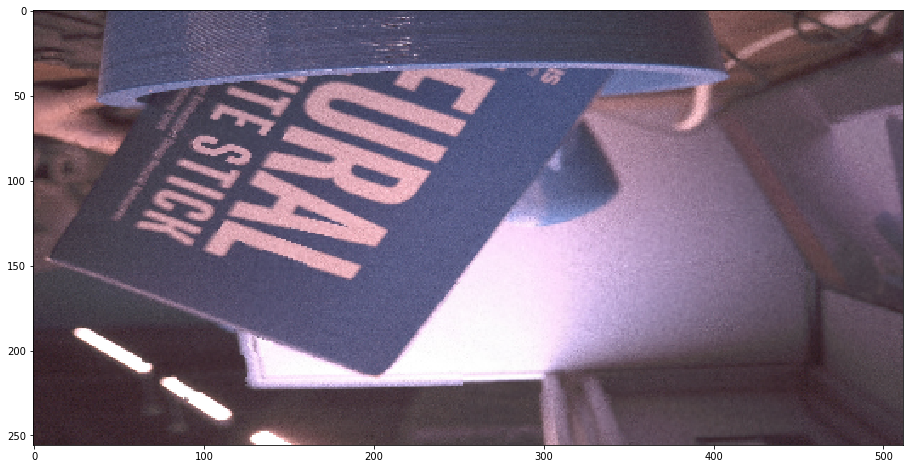

In [10]:
# import cv2
# img1 = imgs[0]
# img2 = imgs[1]
# img3 = imgs[2]

# img_size = (1024, 512)

# img1 = cv2.resize(img1, img_size)/255.
# img2 = cv2.resize(img2, img_size)/255.
# img3 = cv2.resize(img3, img_size)/255.

fused = FusionNet.predict([np.expand_dims(img1, axis=0), warp.cpu().numpy().transpose(0, 2, 3, 1)])[0]
fig = plt.figure(figsize=(16, 8))
plt.imshow(fused[0])
plt.show()

# fused = FusionNet.predict([fused, np.expand_dims(img3, axis=0)])[0]
# fig = plt.figure(figsize=(16, 8))
# plt.imshow(fused[0])
# plt.show()

In [11]:
# ## multifocus fusion
# def padding(img, left, up):
    
#     return np.pad(img, ((up, up), (left, left), (0, 0)), 'constant')

# def crop(img, left, up):
#     if left >0 and up > 0:
#         return img[up:-up, left:-left]
#     if left == 0 and up == 0:
#         return img
#     if left > 0 and up ==0:
#         return img[:, left:-left]
#     if up > 0 and left == 0:
#         return img[up:-up]

# def fuse_img(start_img, next_img):
#     H, W, C = start_img.shape
#     left = 0
#     up = 0
#     if H % 256 != 0:
#         up = (256 - (H % 256))//2
#     if W % 256 != 0:
#         left = (256 - (W % 256))//2
#     start_img = padding(start_img, left, up)
#     next_img = padding(next_img, left, up)
#     H, W, C = start_img.shape
    
#     fused_img = np.zeros(start_img.shape)
#     start_img = start_img[np.newaxis, ...] *2 -1
#     next_img = next_img[np.newaxis, ...] *2 -1

#     for i in range(0, H, 256):
#         for j in range(0, W, 256):
#             fused_img[i:i+256, j:j+256, :] = FusionNet.predict(
#                 [start_img[:, i:i+256, j:j+256, :], next_img[:, i:i+256, j:j+256, :]])[0]
    
#     fused_img = crop(fused_img, left, up)/2+0.5
#     return fused_img
    

# def multifocus_fusion(imgs):
#     start_img = imgs[0]
# #     imgs_fused = []
# #     imgs_fused.append(start_img)
    
#     for i in range(1, imgs.shape[0]):
#         next_img = imgs[i]
#         img_fused = fuse_img(start_img, next_img)
# #         imgs_fused.append(img_fused)
#         start_img = img_fused

#     return img_fused

In [12]:
# img = multifocus_fusion(imgs/255.)
# fig = plt.figure(figsize=(16, 8))
# plt.imshow(img)
# plt.show()

In [33]:
int(time.time()%100000)

90678